## Essentials lib import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Dataset

In [6]:
# Load CSV files ---
data_path = "/content/data"  # adapte si nécessaire
Xtr = pd.read_csv(os.path.join(data_path, "Xtr.csv"))
Xte = pd.read_csv(os.path.join(data_path, "Xte.csv"))
Ytr = pd.read_csv(os.path.join(data_path, "Ytr.csv"))
Xtr_mat = pd.read_csv(os.path.join(data_path, "Xtr_mat100.csv"), sep='\s+', header=None)
Xte_mat = pd.read_csv(os.path.join(data_path, "Xte_mat100.csv"), sep='\s+', header=None)

## Data Exploration

Xtr shape: (2000, 2)
Ytr shape: (2000, 2)
Xte shape: (1000, 2)

Sample sequence from Xtr:
0


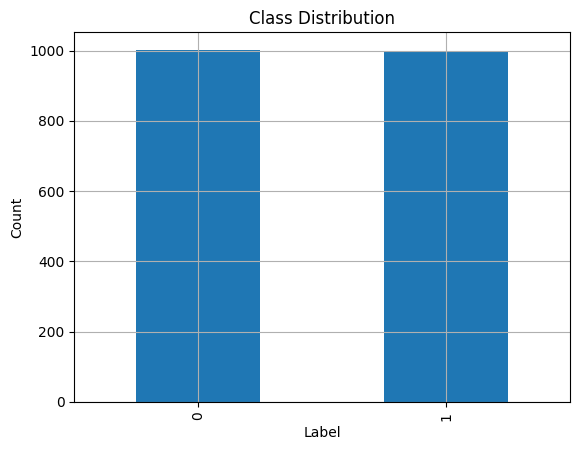

In [7]:
# [3] Quick data check
print("Xtr shape:", Xtr.shape)
print("Ytr shape:", Ytr.shape)
print("Xte shape:", Xte.shape)

print("\nSample sequence from Xtr:")
print(Xtr.iloc[0, 0])

# Check class distribution
Ytr['Bound'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid()
plt.show()

### Prepare PyTorch tensors from precomputed features (fixed for space-separated data)

In [8]:
# Load as space-delimited (not comma)
Xtr_mat = pd.read_csv(os.path.join(data_path, "Xtr_mat100.csv"), delim_whitespace=True, header=None, dtype=np.float32)
Xte_mat = pd.read_csv(os.path.join(data_path, "Xte_mat100.csv"), delim_whitespace=True, header=None, dtype=np.float32)

# Convert to PyTorch tensors
X = torch.tensor(Xtr_mat.values, dtype=torch.float32)
y = torch.tensor(Ytr["Bound"].values, dtype=torch.float32)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Wrap into Datasets and Loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

<ipython-input-8-6134d1b622ba>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xtr_mat = pd.read_csv(os.path.join(data_path, "Xtr_mat100.csv"), delim_whitespace=True, header=None, dtype=np.float32)
<ipython-input-8-6134d1b622ba>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Xte_mat = pd.read_csv(os.path.join(data_path, "Xte_mat100.csv"), delim_whitespace=True, header=None, dtype=np.float32)


Training samples: 1600, Validation samples: 400


### Data Preprocessing & Feature Engineering

In [9]:
def extract_kmers(seq, k=10):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

In [10]:
def kmer_to_onehot(kmer):
    mapping = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in kmer]).flatten()
# Convert full sequences to one-hot tensors (shape: N x 100 x 4)
def full_sequence_to_onehot(seq):
    mapping = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in seq])

X_seq = np.array([full_sequence_to_onehot(seq) for seq in Xtr["seq"]])
X_test_seq = np.array([full_sequence_to_onehot(seq) for seq in Xte["seq"]])


In [11]:
def all_kmer_onehots(sequences, k=10):
    all_kmers = []
    for seq in tqdm(sequences):
        kmers = extract_kmers(seq, k)
        all_kmers.extend([kmer_to_onehot(k) for k in kmers])
    return np.array(all_kmers)

all_kmer_vectors = all_kmer_onehots(Xtr["seq"], k=10)
print("Total k-mers:", all_kmer_vectors.shape)

100%|██████████| 2000/2000 [00:01<00:00, 1024.71it/s]


Total k-mers: (184000, 40)


In [12]:
from sklearn.cluster import KMeans

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(all_kmer_vectors)

KMeans(n_clusters=50, n_init=10, random_state=42)

###  Clustering-based Feature Extraction with k-mers

In [13]:
def sequence_to_cluster_vector(seq, k=10):
    kmers = extract_kmers(seq, k)
    vectors = [kmer_to_onehot(k) for k in kmers]
    cluster_ids = kmeans.predict(vectors)
    cluster_onehots = np.zeros((len(cluster_ids), n_clusters), dtype=np.float32)
    for i, cluster_id in enumerate(cluster_ids):
        cluster_onehots[i, cluster_id] = 1
    return cluster_onehots.mean(axis=0)

X_cluster = np.array([sequence_to_cluster_vector(seq) for seq in tqdm(Xtr["seq"])])
X_test_cluster = np.array([sequence_to_cluster_vector(seq) for seq in tqdm(Xte["seq"])])


100%|██████████| 1000/1000 [00:01<00:00, 665.28it/s]


### Preprocessing: Normalization and Tensor Conversion

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster)
X_test_cluster = scaler.transform(X_test_cluster)

# Convert to PyTorch tensors
X_seq_tensor = torch.tensor(X_seq).permute(0, 2, 1)
X_cluster_tensor = torch.tensor(X_cluster, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq).permute(0, 2, 1)
X_test_cluster_tensor = torch.tensor(X_test_cluster, dtype=torch.float32)
y_tensor = torch.tensor(Ytr["Bound"].values, dtype=torch.float32)

### Dataset & Dataloaders: Dual Input Pipeline

In [15]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

X_seq_train, X_seq_val, X_clust_train, X_clust_val, y_train, y_val = train_test_split(
    X_seq_tensor, X_cluster_tensor, y_tensor, test_size=0.2, random_state=42)

class DualInputDataset(torch.utils.data.Dataset):
    def __init__(self, seq_tensor, clust_tensor, labels):
        self.seq = seq_tensor
        self.clust = clust_tensor
        self.labels = labels

    def __getitem__(self, idx):
        return self.seq[idx], self.clust[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

train_dataset = DualInputDataset(X_seq_train, X_clust_train, y_train)
val_dataset = DualInputDataset(X_seq_val, X_clust_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## SUBMISSION 7 - Ensemble CNN+KMeans + CNN-only (Avg Fusion)

In [20]:
# One-hot encoding function
def one_hot_encode_seq(seq, maxlen=101):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((4, maxlen), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in mapping:
            one_hot[mapping[char], i] = 1.0
    return one_hot

# Apply one-hot to all sequences
X_seq = np.stack([one_hot_encode_seq(seq) for seq in Xtr["seq"]])
X_test_seq = np.stack([one_hot_encode_seq(seq) for seq in Xte["seq"]])

# Convert all to PyTorch tensors
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_tensor = torch.tensor(Ytr["Bound"].values, dtype=torch.float32)

X_cluster_tensor = torch.tensor(Xtr_mat.values, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(Xte_mat.values, dtype=torch.float32)

print("All data loaded and encoded.")
print(f"Train sequences shape: {X_seq_tensor.shape}")
print(f"Test sequences shape:  {X_test_seq_tensor.shape}")

All data loaded and encoded.
Train sequences shape: torch.Size([2000, 4, 101])
Test sequences shape:  torch.Size([1000, 4, 101])


In [21]:
# Normalize KMeans features ---
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster)
X_test_cluster = scaler.transform(X_test_cluster)

X_cluster_tensor = torch.tensor(X_cluster, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(X_test_cluster, dtype=torch.float32)

# Prepare train/val split
X_seq_train, X_seq_val, X_clust_train, X_clust_val, y_train, y_val = train_test_split(
    X_seq_tensor, X_cluster_tensor, y_tensor, test_size=0.2, random_state=42)

# Dataset for CNN+KMeans
class DualInputDataset(Dataset):
    def __init__(self, seq_tensor, clust_tensor, labels):
        self.seq = seq_tensor
        self.clust = clust_tensor
        self.labels = labels

    def __getitem__(self, idx):
        return self.seq[idx], self.clust[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

train_dataset = DualInputDataset(X_seq_train, X_clust_train, y_train)
val_dataset = DualInputDataset(X_seq_val, X_clust_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# CNN+KMeans model (pre-trained)
class CNNKMeansFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=9, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.mlp = nn.Sequential(
            nn.Linear(256 + 50, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, x_clust):
        x_cnn = self.cnn(x_seq)
        x_concat = torch.cat([x_cnn, x_clust], dim=1)
        return self.mlp(x_concat)

In [66]:
# CNN-only model (new training)
class CNNOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model2 = CNNOnly()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.003)
# Train CNN-only model with validation accuracy
def compute_accuracy(preds, labels):
    preds = (preds >= 0.5).float()
    correct = (preds == labels).float().sum()
    return correct / len(labels)

for epoch in range(20):
    model2.train()
    total_loss = 0
    for xb, _, yb in train_loader:
        preds = model2(xb).squeeze()
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # --- Validation ---
    model2.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for xb, _, yb in val_loader:
            preds = model2(xb).squeeze()
            val_preds.append(preds)
            val_targets.append(yb)
    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)
    val_acc = compute_accuracy(val_preds, val_targets)

    print(f"Epoch {epoch+1:02d} - Loss: {total_loss/len(train_loader):.4f} - Val Accuracy: {val_acc:.4f}")

Epoch 01 - Loss: 0.7006 - Val Accuracy: 0.6175
Epoch 02 - Loss: 0.6762 - Val Accuracy: 0.6150
Epoch 03 - Loss: 0.5769 - Val Accuracy: 0.6950
Epoch 04 - Loss: 0.4871 - Val Accuracy: 0.6850
Epoch 05 - Loss: 0.3986 - Val Accuracy: 0.6875
Epoch 06 - Loss: 0.2572 - Val Accuracy: 0.7050
Epoch 07 - Loss: 0.1765 - Val Accuracy: 0.7025
Epoch 08 - Loss: 0.0798 - Val Accuracy: 0.6950
Epoch 09 - Loss: 0.0295 - Val Accuracy: 0.6625
Epoch 10 - Loss: 0.0872 - Val Accuracy: 0.6925
Epoch 11 - Loss: 0.0249 - Val Accuracy: 0.6825
Epoch 12 - Loss: 0.0105 - Val Accuracy: 0.7000
Epoch 13 - Loss: 0.0074 - Val Accuracy: 0.6975
Epoch 14 - Loss: 0.0026 - Val Accuracy: 0.7025
Epoch 15 - Loss: 0.0010 - Val Accuracy: 0.6950
Epoch 16 - Loss: 0.0008 - Val Accuracy: 0.7000
Epoch 17 - Loss: 0.0006 - Val Accuracy: 0.7025
Epoch 18 - Loss: 0.0006 - Val Accuracy: 0.7025
Epoch 19 - Loss: 0.0005 - Val Accuracy: 0.6925
Epoch 20 - Loss: 0.0004 - Val Accuracy: 0.6950


In [68]:
# Generate predictions
with torch.no_grad():
    preds1 = model1(X_test_seq_tensor, X_test_cluster_tensor).squeeze()
    preds2 = model2(X_test_seq_tensor).squeeze()

    avg_preds = ((preds1 + preds2) / 2).cpu().numpy()
    final_preds = (avg_preds >= 0.5).astype(int)

In [27]:
# Create submission.csv
with open("submission.csv", "w") as f:
    f.write("Id,Bound\n")
    for i, p in enumerate(final_preds):
        f.write(f"{i},{p}\n")

print("Ensemble submission.csv ready")
# Submit (when ready)
!kaggle competitions submit -c dna-intro-to-neural-nets-aims-rwanda-2025 -f submission.csv -m "Submission 11 - Ensemble (CNN+KMeans + CNN-only avg)"

Ensemble submission.csv ready


## Submission 11



In [31]:
#  Submission 11 - Triple Ensemble (CNN+KMeans, CNNOnly, MLP on Clusters)

# Normalize KMeans features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster)
X_test_cluster = scaler.transform(X_test_cluster)

X_cluster_tensor = torch.tensor(X_cluster, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(X_test_cluster, dtype=torch.float32)

# Train/Val Split
X_seq_train, X_seq_val, X_clust_train, X_clust_val, y_train, y_val = train_test_split(
    X_seq_tensor, X_cluster_tensor, y_tensor, test_size=0.2, random_state=42)

# Dataset Class
class DualInputDataset(Dataset):
    def __init__(self, seq_tensor, clust_tensor, labels):
        self.seq = seq_tensor
        self.clust = clust_tensor
        self.labels = labels

    def __getitem__(self, idx):
        return self.seq[idx], self.clust[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

train_dataset = DualInputDataset(X_seq_train, X_clust_train, y_train)
val_dataset = DualInputDataset(X_seq_val, X_clust_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Models
class CNNKMeansFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=9, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.mlp = nn.Sequential(
            nn.Linear(256 + 50, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, x_clust):
        x_cnn = self.cnn(x_seq)
        x_concat = torch.cat([x_cnn, x_clust], dim=1)
        return self.mlp(x_concat)

class CNNOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class MLPOnClusters(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(50, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Instantiate models
model1 = CNNKMeansFusion()
model2 = CNNOnly()
model3 = MLPOnClusters()

# Loss + Optimizers
loss_fn = nn.BCELoss()
opt1 = torch.optim.Adam(model1.parameters(), lr=0.002)
opt2 = torch.optim.Adam(model2.parameters(), lr=0.003)
opt3 = torch.optim.Adam(model3.parameters(), lr=0.001)

# --- 5. Training (Simple Loop for each model) ---
def train_model(model, optimizer, train_loader, val_loader, mode="cnn_only"):
    best_acc = 0.0
    for epoch in range(20):
        model.train()
        total_loss = 0
        for xb, xc, yb in train_loader:
            if mode == "cnn_only":
                preds = model(xb).squeeze()
            elif mode == "mlp":
                preds = model(xc).squeeze()
            else:
                preds = model(xb, xc).squeeze()

            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, xc, yb in val_loader:
                if mode == "cnn_only":
                    preds = model(xb).squeeze()
                elif mode == "mlp":
                    preds = model(xc).squeeze()
                else:
                    preds = model(xb, xc).squeeze()
                all_preds.append(preds)
                all_targets.append(yb)
        val_preds = torch.cat(all_preds)
        val_targets = torch.cat(all_targets)
        acc = ((val_preds >= 0.5).float() == val_targets).float().mean().item()
        print(f"[{mode}] Epoch {epoch+1:03d} - Loss: {total_loss/len(train_loader):.4f} - Val Accuracy: {acc:.4f} - Best: {max(acc, best_acc):.4f}")
        best_acc = max(acc, best_acc)

# Train all 3 models
print("🔧 Training CNN+KMeans model...")
train_model(model1, opt1, train_loader, val_loader, mode="cnn_kmeans")
print("\n🔧 Training CNNOnly model...")
train_model(model2, opt2, train_loader, val_loader, mode="cnn_only")
print("\n🔧 Training MLPOnClusters model...")
train_model(model3, opt3, train_loader, val_loader, mode="mlp")

🔧 Training CNN+KMeans model...
[cnn_kmeans] Epoch 001 - Loss: 0.7181 - Val Accuracy: 0.6125 - Best: 0.6125
[cnn_kmeans] Epoch 002 - Loss: 0.6745 - Val Accuracy: 0.6800 - Best: 0.6800
[cnn_kmeans] Epoch 003 - Loss: 0.5962 - Val Accuracy: 0.6450 - Best: 0.6800
[cnn_kmeans] Epoch 004 - Loss: 0.5336 - Val Accuracy: 0.7250 - Best: 0.7250
[cnn_kmeans] Epoch 005 - Loss: 0.4237 - Val Accuracy: 0.6575 - Best: 0.7250
[cnn_kmeans] Epoch 006 - Loss: 0.3424 - Val Accuracy: 0.6650 - Best: 0.7250
[cnn_kmeans] Epoch 007 - Loss: 0.2832 - Val Accuracy: 0.6850 - Best: 0.7250
[cnn_kmeans] Epoch 008 - Loss: 0.2030 - Val Accuracy: 0.6825 - Best: 0.7250
[cnn_kmeans] Epoch 009 - Loss: 0.1572 - Val Accuracy: 0.6875 - Best: 0.7250
[cnn_kmeans] Epoch 010 - Loss: 0.1164 - Val Accuracy: 0.6750 - Best: 0.7250
[cnn_kmeans] Epoch 011 - Loss: 0.0929 - Val Accuracy: 0.6500 - Best: 0.7250
[cnn_kmeans] Epoch 012 - Loss: 0.1238 - Val Accuracy: 0.6725 - Best: 0.7250
[cnn_kmeans] Epoch 013 - Loss: 0.0826 - Val Accuracy: 0.6

In [2]:
# --- 7. Generate predictions (Ensemble 60/40) ---
with torch.no_grad():
    preds1 = model1(X_test_seq_tensor, X_test_cluster_tensor).squeeze()
    preds2 = model2(X_test_seq_tensor).squeeze()
    final_preds = (0.6 * preds1 + 0.4 * preds2 >= 0.5).int().cpu().numpy()

# --- 8. Save submission file ---
with open("submission11.csv", "w") as f:
    f.write("Id,Bound\n")
    for i, p in enumerate(final_preds):
        f.write(f"{i},{p}\n")

print("Submission file 'submission.csv' ready.")

NameError: name 'torch' is not defined

In [1]:
# Submit
!kaggle competitions submit -c dna-intro-to-neural-nets-aims-rwanda-2025 -f submission12.csv -m "Submission 12 - Ensemble (CNN+KMeans + CNN-only avg)"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


### Other

In [45]:
# --- One-hot encoding ---
def one_hot_encode_seq(seq, maxlen=101):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((4, maxlen), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in mapping:
            one_hot[mapping[char], i] = 1.0
    return one_hot

X_seq = np.stack([one_hot_encode_seq(seq) for seq in Xtr["seq"]])
X_test_seq = np.stack([one_hot_encode_seq(seq) for seq in Xte["seq"]])

X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_tensor = torch.tensor(Ytr["Bound"].values, dtype=torch.float32)

X_cluster = StandardScaler().fit_transform(Xtr_mat.values)
X_test_cluster = StandardScaler().fit_transform(Xte_mat.values)
X_cluster_tensor = torch.tensor(X_cluster, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(X_test_cluster, dtype=torch.float32)

# --- Data preparation ---
X_seq_train, X_seq_val, X_clust_train, X_clust_val, y_train, y_val = train_test_split(
    X_seq_tensor, X_cluster_tensor, y_tensor, test_size=0.2, random_state=42)

class DualInputDataset(Dataset):
    def __init__(self, seq_tensor, clust_tensor, labels):
        self.seq = seq_tensor
        self.clust = clust_tensor
        self.labels = labels

    def __getitem__(self, idx):
        return self.seq[idx], self.clust[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

train_dataset = DualInputDataset(X_seq_train, X_clust_train, y_train)
val_dataset = DualInputDataset(X_seq_val, X_clust_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# --- Models ---
class CNNKMeansFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=9, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.mlp = nn.Sequential(
            nn.Linear(256 + 100, 256),  # 256 from CNN, 100 from KMeans
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, x_clust):
        x_cnn = self.cnn(x_seq)
        x_concat = torch.cat([x_cnn, x_clust], dim=1)
        return self.mlp(x_concat)

class CNNOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class MLPOnClusters(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 64),  # 🔧 fix here
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Instantiate models
model1 = CNNKMeansFusion()
model2 = CNNOnly()
model3 = MLPOnClusters()

loss_fn = nn.BCELoss()
opt1 = torch.optim.Adam(model1.parameters(), lr=0.002)
opt2 = torch.optim.Adam(model2.parameters(), lr=0.003)
opt3 = torch.optim.Adam(model3.parameters(), lr=0.001)

def train_model(model, optimizer, train_loader, val_loader, mode="cnn_only"):
    best_acc = 0.0
    for epoch in range(30):
        model.train()
        total_loss = 0
        for xb, xc, yb in train_loader:
            if mode == "cnn_only":
                preds = model(xb).squeeze()
            elif mode == "mlp":
                preds = model(xc).squeeze()
            else:
                preds = model(xb, xc).squeeze()

            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, xc, yb in val_loader:
                if mode == "cnn_only":
                    preds = model(xb).squeeze()
                elif mode == "mlp":
                    preds = model(xc).squeeze()
                else:
                    preds = model(xb, xc).squeeze()
                all_preds.append(preds)
                all_targets.append(yb)
        val_preds = torch.cat(all_preds)
        val_targets = torch.cat(all_targets)
        acc = ((val_preds >= 0.5).float() == val_targets).float().mean().item()
        print(f"[{mode}] Epoch {epoch+1:02d} - Loss: {total_loss/len(train_loader):.4f} - Val Accuracy: {acc:.4f} - Best: {max(acc, best_acc):.4f}")
        best_acc = max(acc, best_acc)

# --- Train all models ---
print("\n🔧 Training CNN+KMeans model...")
train_model(model1, opt1, train_loader, val_loader, mode="cnn_kmeans")
print("\n🔧 Training CNNOnly model...")
train_model(model2, opt2, train_loader, val_loader, mode="cnn_only")
print("\n🔧 Training MLPOnClusters model...")
train_model(model3, opt3, train_loader, val_loader, mode="mlp")


🔧 Training CNN+KMeans model...
[cnn_kmeans] Epoch 01 - Loss: 0.7163 - Val Accuracy: 0.4850 - Best: 0.4850
[cnn_kmeans] Epoch 02 - Loss: 0.6503 - Val Accuracy: 0.6600 - Best: 0.6600
[cnn_kmeans] Epoch 03 - Loss: 0.5700 - Val Accuracy: 0.5625 - Best: 0.6600
[cnn_kmeans] Epoch 04 - Loss: 0.4967 - Val Accuracy: 0.6975 - Best: 0.6975
[cnn_kmeans] Epoch 05 - Loss: 0.4102 - Val Accuracy: 0.6700 - Best: 0.6975
[cnn_kmeans] Epoch 06 - Loss: 0.3248 - Val Accuracy: 0.6550 - Best: 0.6975
[cnn_kmeans] Epoch 07 - Loss: 0.3157 - Val Accuracy: 0.6850 - Best: 0.6975
[cnn_kmeans] Epoch 08 - Loss: 0.1960 - Val Accuracy: 0.6950 - Best: 0.6975
[cnn_kmeans] Epoch 09 - Loss: 0.1917 - Val Accuracy: 0.6950 - Best: 0.6975
[cnn_kmeans] Epoch 10 - Loss: 0.0948 - Val Accuracy: 0.6875 - Best: 0.6975
[cnn_kmeans] Epoch 11 - Loss: 0.0992 - Val Accuracy: 0.6600 - Best: 0.6975
[cnn_kmeans] Epoch 12 - Loss: 0.0833 - Val Accuracy: 0.6850 - Best: 0.6975
[cnn_kmeans] Epoch 13 - Loss: 0.1039 - Val Accuracy: 0.7000 - Best: 

In [58]:
# Generate predictions from CNN+KMeans and CNNOnly
with torch.no_grad():
    preds1 = model1(X_test_seq_tensor, X_test_cluster_tensor).squeeze()
    preds2 = model2(X_test_seq_tensor).squeeze()

    alpha = 0.27
    final_probs = (alpha * preds1 + (1 - alpha) * preds2).cpu().numpy()
    final_preds = (final_probs >= 0.5).astype(int)

#  savesubmission file
submission_name = "sub10.csv"
with open(submission_name, "w") as f:
    f.write("Id,Bound\n")
    for i, p in enumerate(final_preds):
        f.write(f"{i},{p}\n")

print(f"Submission file '{submission_name}' generated successfully.")

Submission file 'sub10.csv' generated successfully.


In [59]:
from google.colab import files
files.download(submission_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
!kaggle competitions submit -c dna-intro-to-neural-nets-aims-rwanda-2025 -f submission_cnn_kmeans_cnnonly.csv -m "Submission 15 - Weighted ensemble (0.75 CNNOnly, 0.15 CNN+KMeans, 0.10 MLP)"


100% 5.76k/5.76k [00:00<00:00, 31.0kB/s]
400 - Bad Request
